In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adadelta, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
import sklearn
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import time
warnings.filterwarnings('ignore')

## Load dataset

In [2]:
filepath = "data/iot23_combined.csv"
df = pd.read_csv(filepath)

In [3]:
df.replace({False: 0, True: 1}, inplace=True)
df.replace({'False': 0, 'True': 1}, inplace=True)

In [4]:
df = df.dropna()

In [5]:
df

,Unnamed: 0,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,0,2.998796,0,0,0.0,3.0,180.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0.0
1,1,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0.0
2,2,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0.0
3,3,2.998804,0,0,0.0,3.0,180.0,0.0,0.0,Benign,...,0,0,0,1,0,0,0,0,0,0.0
4,4,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,Benign,...,0,0,0,1,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636310,6685,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0.0
636311,6686,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0.0
636312,6687,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0.0
636313,6688,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0.0


In [6]:
df.describe()

,Unnamed: 0,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,proto_icmp,...,conn_state_RSTO,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SHR
count,636315.000000,636315.000000,6.363150e+05,6.363150e+05,636315.000000,636315.000000,6.363150e+05,636315.000000,6.363150e+05,636315.000000,...,636315.000000,636315.000000,636315.000000,636315.000000,636315.000000,636315.000000,636315.000000,636315.000000,636315.000000,636315.000000
mean,47617.554576,1.002054,1.280451e+02,3.598637e+01,0.132958,1.907909,2.216029e+02,0.250638,4.780504e+01,0.005379,...,0.000214,0.000035,0.000545,0.000008,0.947644,0.000072,0.000038,0.002489,0.017548,0.000002
std,29702.027644,122.449261,9.477827e+04,1.463941e+04,23.648299,40.134193,9.543589e+04,23.246132,1.518818e+04,0.073147,...,0.014618,0.005880,0.023346,0.002803,0.222744,0.008502,0.006141,0.049831,0.131301,0.001254
min,0.000000,-1.000000,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20842.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,4.000000e+01,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,46972.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,6.000000e+01,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,73485.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,2.000000,8.000000e+01,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,99998.000000,48976.819063,7.554662e+07,1.166102e+07,5792.000000,18444.000000,7.606306e+07,9307.000000,1.207699e+07,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Explore Dataset Analysis

In [7]:
del df['Unnamed: 0']

In [8]:
# Step 1: Check for duplicated rows
duplicates = df.duplicated()

# Step 2: Count the occurrences of duplicates
duplicate_counts = duplicates.sum()
print("Number of duplicated rows:", duplicate_counts)

Number of duplicated rows: 594085


In [9]:
# Step 3: Remove duplicated rows
df = df.drop_duplicates()

# Step 4: Verify that duplicates have been removed
duplicates_after_removal = df.duplicated().sum()
print("Number of duplicated rows after removal:", duplicates_after_removal)

Number of duplicated rows after removal: 0


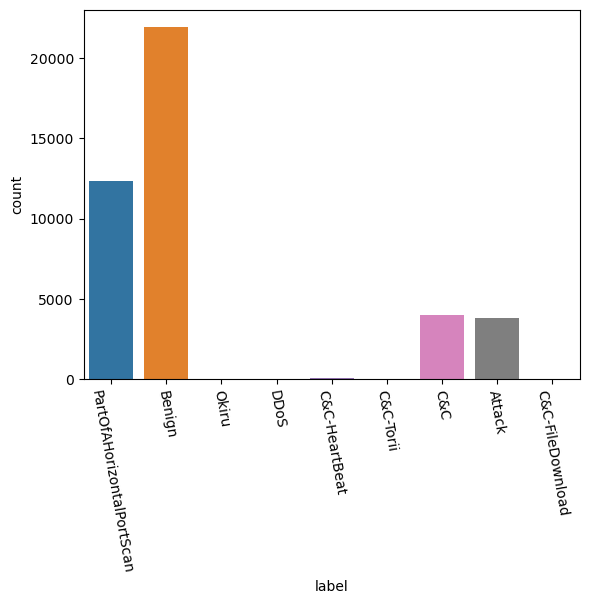

In [10]:
sns.countplot(x='label', data=df)
plt.xticks(rotation=-80)
plt.show()

Here's a brief explanation of each label

- **PartOfAHorizontalPortScan:** A large number of connection attempts to various ports across multiple hosts, typically to discover open ports and vulnerable services. This activity is a common precursor to more targeted attacks.

- **Okiru:** Associated with the Okiru malware, which targets IoT devices. Okiru is known for its capability to infect routers and other connected devices.
- **Benign:** Normal, non-malicious network traffic that does not pose a security threat. This label is crucial for training models to distinguish between harmful and harmless activities.
- **DDoS (Distributed Denial of Service):** Traffic patterns indicative of a DDoS attack, where multiple systems flood the bandwidth or resources of a targeted system, usually one or more web servers.
- **C&C (Command and Control):** Traffic associated with command and control servers, which attackers use to communicate with and control compromised systems within a botnet or malware-infected network.
- **C&C-HeartBeat:** A specific type of C&C traffic that involves periodic signals (heartbeats) sent from compromised devices to a C&C server to indicate the device is still active and connected.
- **Attack:** A general label for traffic that is part of a network attack, which could involve unauthorized access, data exfiltration, or other malicious activities.
- **C&C-FileDownload:** Traffic indicating that a compromised device is downloading files from a C&C server, potentially indicating the download of malware, updates to existing malware, or malicious configurations.
- **C&C-Torii:** Activity related to the Torii botnet, which is known for its sophisticated design and versatility in targeting various platforms and devices.

## Remove illogical data

In [11]:
df.duration.unique()

array([2.998796, 0.      , 2.998804, ..., 9.092066, 9.007351, 0.012241])

Negative values on duration colums is illogical data so we will not use it.

In [12]:
df[(df['duration'] < 0)].shape[0]

17

In [13]:
df = df[(df['duration'] >= 0)]
df[(df['duration'] < 0)].shape[0]

0

### Correlation table heatmap

<AxesSubplot:>

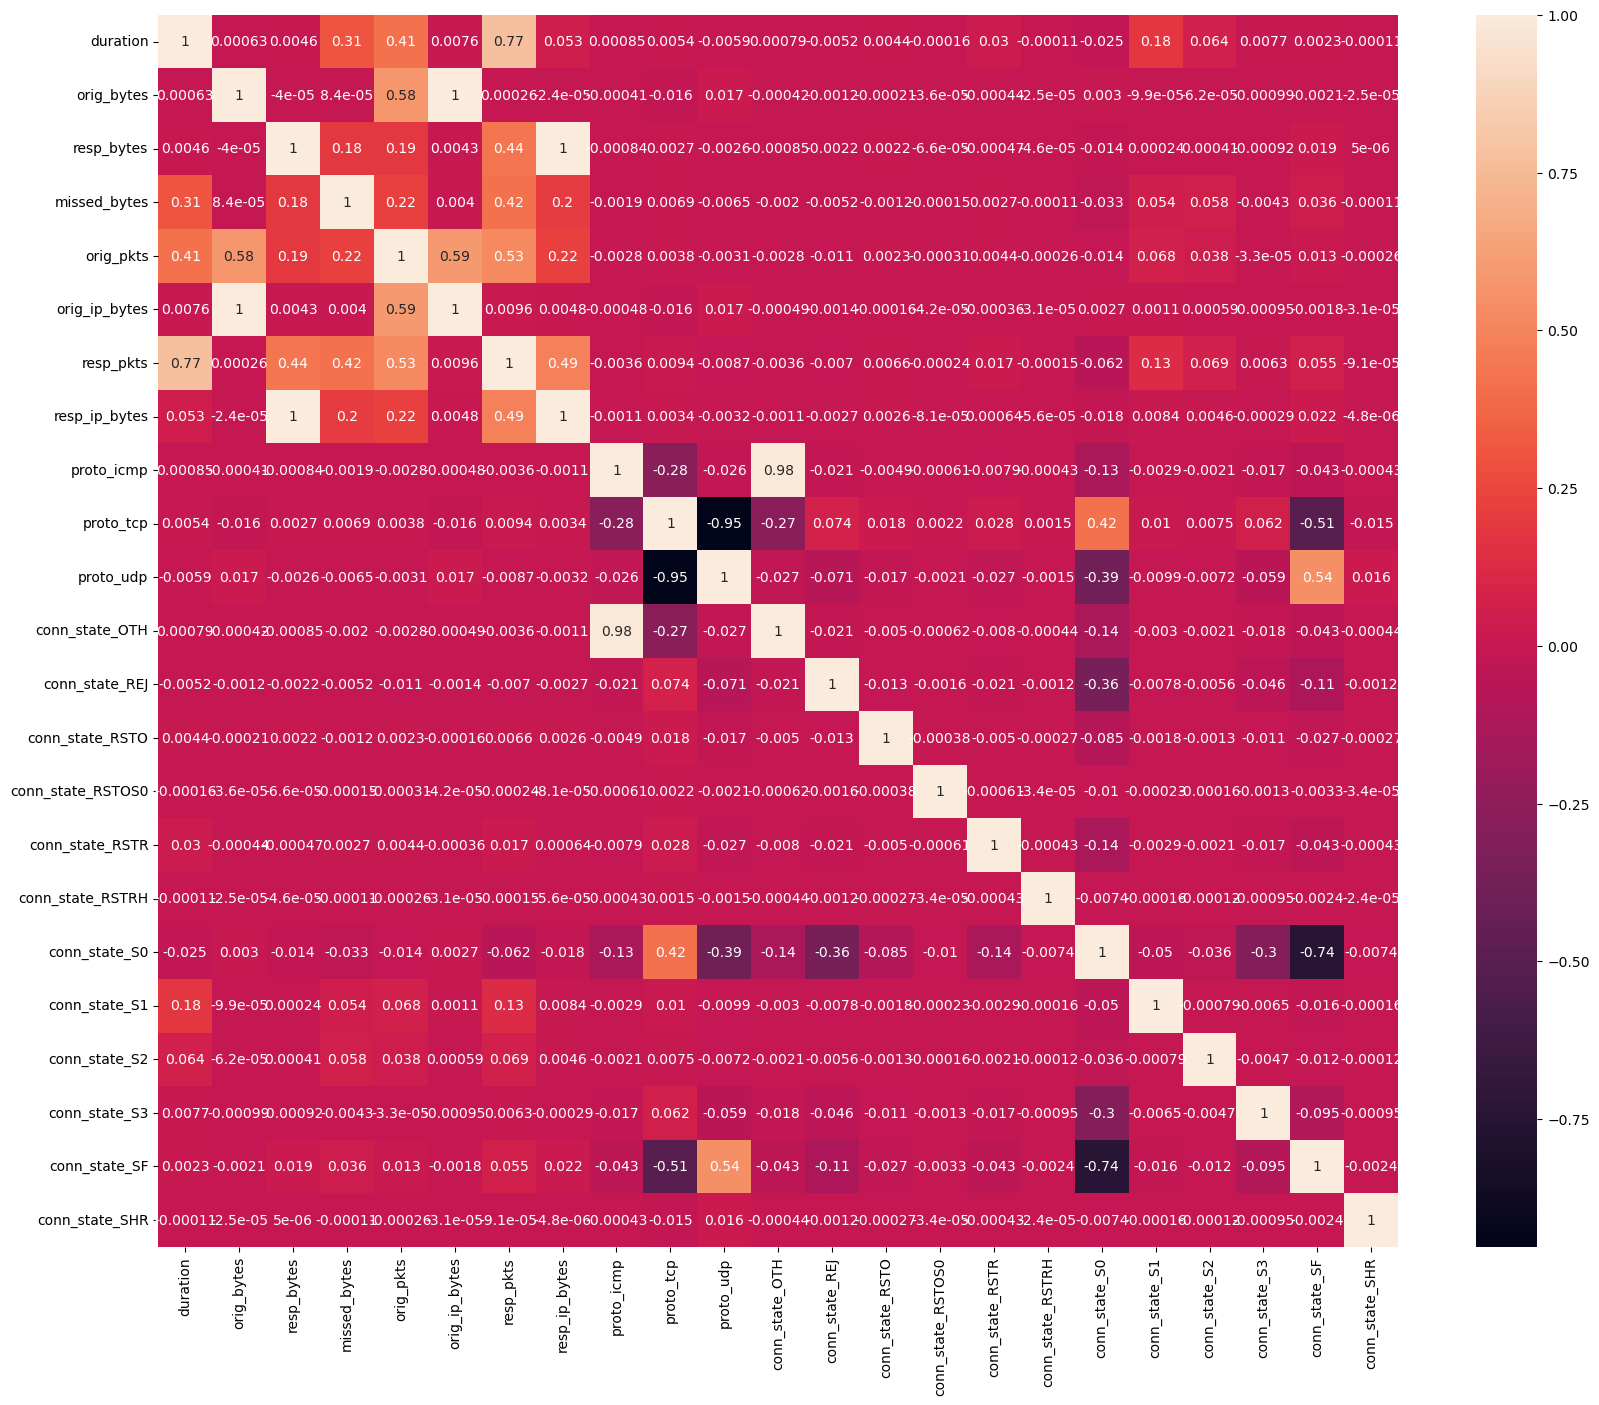

In [14]:
plt.figure(figsize = (20,16))
sns.heatmap(df.drop("label", axis = 1).corr(),annot=True)

Based on heatmap model we will 'remove conn_state_S0', 'conn_state_SF', 'proto_tcp' feature because these features will have proportional and inverse proportional with other features.

In [17]:
X = df[['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'proto_icmp', 'proto_udp', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_RSTRH', 'conn_state_S1', 'conn_state_S2', 'conn_state_S3', 'conn_state_SH', 'conn_state_SHR']].values


In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X.shape

(42213, 21)

In [20]:
Y = pd.get_dummies(df['label']).values

In [21]:
Y.shape

(42213, 9)

Applied MinMaxScaler to reduce the range of values of each features in data

In [22]:
scaler = MinMaxScaler()

In [23]:
scaler.fit(X)

MinMaxScaler()

In [24]:
normalized_x = scaler.transform(X)

In [25]:
normalized_x.shape

(42213, 21)

In [26]:
# Split data into independent and dependent variables
# data_X = df.drop("label", axis=1)
data_X = pd.DataFrame(normalized_x)
data_y = df["label"]

Split dataset into 2 parts:
- Training part: Use to train model
- Test part: Use to validation model and compare to find the best model

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_y, random_state=10, test_size=0.2)

## Train Models

### Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB

In [29]:
clf = GaussianNB()
clf.fit(X_train, Y_train)

GaussianNB()

In [30]:
start = time.time()
print('program start...')
print()

clf = GaussianNB().fit(X_train, Y_train)
print()

print('Accurancy Score:')
print(clf.score(X_test, Y_test))
print()

y_pred = clf.fit(X_train, Y_train).predict(X_test)
print(y_pred)
print()

end = time.time()
print('program end...')
print()
print('time cost: ')
print(end - start, 'seconds')

program start...


Accurancy Score:
0.21852422124837143

['C&C-HeartBeat' 'C&C-HeartBeat' 'C&C-HeartBeat' ... 'C&C-HeartBeat'
 'Benign' 'C&C-HeartBeat']

program end...

time cost: 
0.1254262924194336 seconds


In [31]:
print("Classifiction Report :")
print(classification_report(Y_test, y_pred))

Classifiction Report :
                           precision    recall  f1-score   support

                   Attack       0.80      0.99      0.89       729
                   Benign       1.00      0.18      0.30      4360
                      C&C       0.75      0.40      0.52       814
         C&C-FileDownload       0.50      1.00      0.67         2
            C&C-HeartBeat       0.00      1.00      0.00        10
                C&C-Torii       0.00      0.00      0.00         3
                     DDoS       0.45      0.83      0.59         6
                    Okiru       0.02      0.89      0.04         9
PartOfAHorizontalPortScan       0.08      0.00      0.00      2510

                 accuracy                           0.22      8443
                macro avg       0.40      0.59      0.33      8443
             weighted avg       0.68      0.22      0.28      8443



**RESULT TABLE**

|Naive Bayes   |         |         |        |       |
|--------------|---------|---------|--------|-------|
|Metrics       |Precision|Recall   |F1-score|Support|
|--------------|---------|---------|--------|-------|
| accuracy     |         |         | 0.22   | 8443  |
|macro avg     |  0.40   | 0.59    | 0.33   | 8443  |
|weighted avg  |  0.68   | 0.22    | 0.28   | 8443  |
|--------------|---------|---------|--------|-------|
|Time          |         |         |        |0.1392s|

### Decision Tree Classifier

In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
DT = DecisionTreeClassifier()

In [34]:
start = time.time()
print('program start...')
print()

DT.fit(data_X, data_y)
print()

print('prediction:')
y_pred = DT.predict(X_test)
print(y_pred)
print()

print('Accurancy Score:')
score = DT.score(X_test,Y_test)
print(score)

end = time.time()
print('program end...')
print()
print('time cost: ')
print(end - start, 'seconds')

program start...


prediction:
['Benign' 'Benign' 'PartOfAHorizontalPortScan' ...
 'PartOfAHorizontalPortScan' 'Benign' 'PartOfAHorizontalPortScan']

Accurancy Score:
0.9221840577993604
program end...

time cost: 
0.10250186920166016 seconds


In [35]:
print("Classifiction Report :")
print(classification_report(Y_test, y_pred))

Classifiction Report :
                           precision    recall  f1-score   support

                   Attack       1.00      1.00      1.00       729
                   Benign       0.88      0.99      0.93      4360
                      C&C       1.00      0.41      0.58       814
         C&C-FileDownload       1.00      1.00      1.00         2
            C&C-HeartBeat       0.00      0.00      0.00        10
                C&C-Torii       0.00      0.00      0.00         3
                     DDoS       0.86      1.00      0.92         6
                    Okiru       1.00      1.00      1.00         9
PartOfAHorizontalPortScan       0.98      0.96      0.97      2510

                 accuracy                           0.92      8443
                macro avg       0.75      0.71      0.71      8443
             weighted avg       0.93      0.92      0.91      8443



**RESULT TABLE**

|Decision Tree |         |         |        |       |
|--------------|---------|---------|--------|-------|
|Metrics       |Precision|Recall   |F1-score|Support|
|--------------|---------|---------|--------|-------|
| accuracy     |         |         | 0.92   | 8443  |
|macro avg     |  0.75   | 0.71    | 0.71   | 8443  |
|weighted avg  |  0.93   | 0.92    | 0.91   | 8443  |
|--------------|---------|---------|--------|-------|
|Time          |         |         |        |0.1025s|

### SVM Classifier

In [36]:
from sklearn.svm import SVC

In [37]:
SVM_classifier = SVC()

In [38]:
start = time.time()
print('program start...')
print()

SVM_classifier.fit(X_train, Y_train)
print()

print('Accurancy Score:')
print(SVM_classifier.score(X_test, Y_test))
print()

y_pred = SVM_classifier.predict(X_test)
print(y_pred)
print()

end = time.time()
print('program end...')
print()
print('time cost: ')
print(end - start, 'seconds')

program start...


Accurancy Score:
0.5596352007580244

['Benign' 'Benign' 'Benign' ... 'Benign' 'Benign' 'Benign']

program end...

time cost: 
114.32274580001831 seconds


In [39]:
print("Classifiction Report :")
print(classification_report(Y_test, y_pred))

Classifiction Report :
                           precision    recall  f1-score   support

                   Attack       0.00      0.00      0.00       729
                   Benign       0.54      1.00      0.70      4360
                      C&C       1.00      0.39      0.56       814
         C&C-FileDownload       0.00      0.00      0.00         2
            C&C-HeartBeat       0.00      0.00      0.00        10
                C&C-Torii       0.00      0.00      0.00         3
                     DDoS       0.00      0.00      0.00         6
                    Okiru       0.00      0.00      0.00         9
PartOfAHorizontalPortScan       0.72      0.02      0.04      2510

                 accuracy                           0.56      8443
                macro avg       0.25      0.16      0.14      8443
             weighted avg       0.59      0.56      0.43      8443



**RESULT TABLE**

|SVM Classifier|         |         |        |       |
|--------------|---------|---------|--------|-------|
|Metrics       |Precision|Recall   |F1-score|Support|
|--------------|---------|---------|--------|-------|
| accuracy     |         |         | 0.56   |  8443 |
|macro avg     |  0.25   | 0.16    | 0.14   | 8443  |
|weighted avg  |  0.59   | 0.56    | 0.43   | 8443  |
|--------------|---------|---------|--------|-------|
|Time          |         |         |        |124.56s|

### K-Nearest Neighbors

In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [41]:
kneighbors_classifier = KNeighborsClassifier()

In [42]:
start = time.time()
print('program start...')
print()

kneighbors_classifier.fit(X_train, Y_train)
print()

print('Accurancy Score:')
print(kneighbors_classifier.score(X_test, Y_test))
print()

y_pred = kneighbors_classifier.predict(X_test)
print(y_pred)
print()

end = time.time()
print('program end...')
print()
print('time cost: ')
print(end - start, 'seconds')

program start...


Accurancy Score:
0.9058391566978562

['Benign' 'Benign' 'PartOfAHorizontalPortScan' ...
 'PartOfAHorizontalPortScan' 'Benign' 'PartOfAHorizontalPortScan']

program end...

time cost: 
10.82395339012146 seconds


In [43]:
print("Classifiction Report :")
print(classification_report(Y_test, y_pred))

Classifiction Report :
                           precision    recall  f1-score   support

                   Attack       0.99      1.00      1.00       729
                   Benign       0.87      0.97      0.91      4360
                      C&C       0.86      0.41      0.55       814
         C&C-FileDownload       1.00      1.00      1.00         2
            C&C-HeartBeat       0.00      0.00      0.00        10
                C&C-Torii       0.00      0.00      0.00         3
                     DDoS       0.00      0.00      0.00         6
                    Okiru       1.00      0.22      0.36         9
PartOfAHorizontalPortScan       0.96      0.95      0.95      2510

                 accuracy                           0.91      8443
                macro avg       0.63      0.50      0.53      8443
             weighted avg       0.90      0.91      0.90      8443



**RESULT TABLE**

|K-Nearest Neighbors  |         |         |        |       |
|---------------------|---------|---------|--------|-------|
|Metrics              |Precision|Recall   |F1-score|Support|
|---------------------|---------|---------|--------|-------|
| accuracy            |         |         | 0.91   |  8443 |
|macro avg            |  0.63   | 0.50    | 0.53   | 8443  |
|weighted avg         |  0.90   | 0.91    | 0.90   | 8443  |
|---------------------|---------|---------|--------|-------|
|Time                 |         |         |        |10.824s|

### XGBoost

In [44]:
!pip install xgboost

In [45]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [46]:
le = LabelEncoder()
Y_train_transformed = le.fit_transform(Y_train)
Y_test_transformed = le.fit_transform(Y_test)

In [47]:
xgb_cls = xgb.XGBClassifier(objective = "binary:logistic", alpha = 10)

In [48]:
start = time.time()
print('program start...')
print()

xgb_cls.fit(X_train, Y_train_transformed)
print()

print('Accurancy Score:')
print(xgb_cls.score(X_test, Y_test_transformed))
print()

y_pred = xgb_cls.predict(X_test)
print(y_pred)
print()

end = time.time()
print('program end...')
print()
print('time cost: ')
print(end - start, 'seconds')

program start...


Accurancy Score:
0.9176832879308303

[1 1 8 ... 8 1 8]

program end...

time cost: 
0.722374439239502 seconds


In [49]:
print("Classifiction Report :")
print(classification_report(Y_test_transformed, y_pred))

Classifiction Report :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       729
           1       0.88      0.98      0.93      4360
           2       1.00      0.40      0.57       814
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         6
           7       0.89      0.89      0.89         9
           8       0.97      0.96      0.96      2510

    accuracy                           0.92      8443
   macro avg       0.52      0.47      0.48      8443
weighted avg       0.92      0.92      0.91      8443



**RESULT TABLE**

|XGBOOST       |         |         |        |       |
|--------------|---------|---------|--------|-------|
|Metrics       |Precision|Recall   |F1-score|Support|
|--------------|---------|---------|--------|-------|
| accuracy     |         |         | 0.92   |  8443 |
|macro avg     |  0.52   | 0.47    | 0.48   | 8443  |
|weighted avg  |  0.92   | 0.92    | 0.91   | 8443  |
|--------------|---------|---------|--------|-------|
|Time          |         |         |        |0.742s |

### Convolutional neural network

In [50]:
scaler = MinMaxScaler()
scaler.fit(Y)
normalized_y = scaler.transform(Y)

In [51]:
X_train_cnn, X_test_cnn, Y_train_cnn, Y_test_cnn = train_test_split(normalized_x, normalized_y, random_state=10, test_size=0.2)

In [52]:
X_train.shape

(33770, 21)

In [53]:
model = Sequential()
model.add(Dense(2048, activation='relu',input_dim=21))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              45056     
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In [55]:
start = time.time()
print('program start...')
print()
callback = EarlyStopping(monitor='accuracy', patience=3)
history = model.fit(X_train_cnn, Y_train_cnn, epochs = 10,callbacks=[callback], batch_size=128, validation_data=(X_test_cnn,Y_test_cnn),verbose=1)

print()
end = time.time()
print('program end...')
print()
print('time cost: ')
print(end - start, 'seconds')

program start...

Epoch 1/10
264/264 [==============================] - 8s 28ms/step - loss: 1.0476 - accuracy: 0.5446 - val_loss: 0.9854 - val_accuracy: 0.5595
Epoch 2/10
264/264 [==============================] - 7s 26ms/step - loss: 0.8817 - accuracy: 0.6025 - val_loss: 0.7545 - val_accuracy: 0.6479
Epoch 3/10
264/264 [==============================] - 7s 27ms/step - loss: 0.7587 - accuracy: 0.6509 - val_loss: 0.7534 - val_accuracy: 0.6508
Epoch 4/10
264/264 [==============================] - 7s 27ms/step - loss: 0.7708 - accuracy: 0.6488 - val_loss: 0.7699 - val_accuracy: 0.6424
Epoch 5/10
264/264 [==============================] - 7s 27ms/step - loss: 0.9163 - accuracy: 0.6024 - val_loss: 0.7316 - val_accuracy: 0.6533
Epoch 6/10
264/264 [==============================] - 8s 28ms/step - loss: 0.7245 - accuracy: 0.6635 - val_loss: 0.7227 - val_accuracy: 0.6583
Epoch 7/10
264/264 [==============================] - 8s 29ms/step - loss: 0.7242 - accuracy: 0.6630 - val_loss: 0.7313 - va

Text(0.5, 1.0, 'Train - Accuracy')

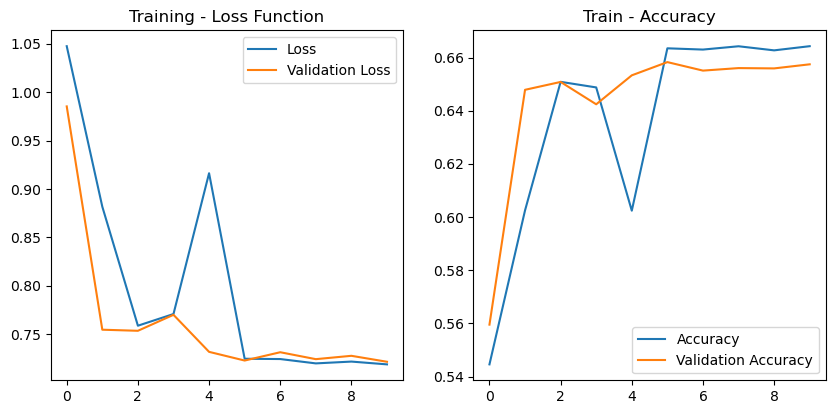

In [56]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

|CNN           |        |         |      |       |
|--------------|--------|---------|------|-------|
| accuracy     |        |         |      |  0.66 |
|--------------|--------|---------|------|-------|
|Time          |        |         |      |75.970s|

## Conclusion

|Models                |Accurancy     |  Time       |
|----------------------|--------------|-------------|
|Naive Bayes           |22%           |0.1392s      |
|SVM Classifier        |56%           |124.56s      |
|K-Nearest Neighbors   |91%           |10.824s      |
|XGBOOST               |92%           |0.742s       |
|**Decision Tree**     |**92%**       |**0.1025s**  |
|CNN                   |66%           |75.970s      |